In [1]:
import pandas as pd
from pysyncon import Dataprep, Synth

In [2]:
covariates = pd.read_csv('../data/scm_covariates/covariates.csv', index_col = 0)
covariates

,STATEFIPS,YEAR,TANF apps / Ind in poverty,Child Poverty Rate,biden_2020_margin
0,1,2000,NaN,0.21,NaN
1,1,2001,NaN,0.23,NaN
2,1,2002,NaN,0.24,NaN
3,1,2003,NaN,0.24,NaN
4,1,2004,NaN,0.23,NaN
...,...,...,...,...,...
1195,56,2019,0.004058,0.12,NaN
1196,56,2020,0.003283,NaN,-0.434
1197,56,2021,0.003346,0.13,NaN
1198,56,2022,NaN,0.14,NaN


In [3]:
snap_gaps = pd.read_csv('../data/estimates/SNAP_gap_estimates/snap_gap_estimates.csv', index_col=0)
snap_gaps

,YEAR,STATEFIPS,SNAP Gap
0,2006,1,0.737655
1,2006,2,0.791812
2,2006,4,0.803563
3,2006,5,0.695652
4,2006,6,0.880446
...,...,...,...
895,2023,51,0.747827
896,2023,53,0.688119
897,2023,54,0.574448
898,2023,55,0.679568


In [4]:
# Get the FIPS codes of all of the non-Massachusetts states
potential_control_fips = snap_gaps['STATEFIPS'].unique()
potential_control_fips = potential_control_fips.tolist()
potential_control_fips.remove(25)

In [5]:
df = pd.merge(snap_gaps, covariates, on = ["YEAR", "STATEFIPS"], how = 'left')
df

,YEAR,STATEFIPS,SNAP Gap,TANF apps / Ind in poverty,Child Poverty Rate,biden_2020_margin
0,2006,1,0.737655,NaN,0.23,NaN
1,2006,2,0.791812,0.013948,0.15,NaN
2,2006,4,0.803563,0.009259,0.20,NaN
3,2006,5,0.695652,0.005160,0.24,NaN
4,2006,6,0.880446,0.007530,0.18,NaN
...,...,...,...,...,...,...
895,2023,51,0.747827,NaN,0.13,NaN
896,2023,53,0.688119,NaN,0.12,NaN
897,2023,54,0.574448,NaN,0.20,NaN
898,2023,55,0.679568,NaN,0.13,NaN


In [6]:
import us

def fips_to_state(fips_code, return_type='abbr'):
    """
    Converts a state FIPS code to its corresponding state abbreviation or name.

    Args:
        fips_code (str): A two-digit FIPS code representing a state.
        return_type (str, optional): Specifies the return type, either 'abbr' for abbreviation (default) or 'name' for full name.

    Returns:
        str: The state abbreviation or name corresponding to the FIPS code.
             Returns None if the FIPS code is invalid.
    """
    fips_code = str(fips_code)
    if len(fips_code) == 1:
        fips_code = '0' + fips_code
    state = us.states.lookup(fips_code)
    if state:
        if return_type == 'abbr':
            return state.abbr
        elif return_type == 'name':
            return state.name
        else:
             raise ValueError("Invalid return_type. Choose 'abbr' or 'name'.")
    return None


In [7]:
df['STATE'] = df['STATEFIPS'].apply(fips_to_state, args=('name',))
df = df.drop(columns = "STATEFIPS")

In [8]:
# Get the FIPS codes of all of the non-Massachusetts states
potential_control_fips = df['STATE'].unique()
potential_control_fips = potential_control_fips.tolist()
potential_control_fips.remove("Massachusetts")

In [9]:
dataprep = Dataprep(
    foo=df,
    predictors=[
        "TANF apps / Ind in poverty",
        "Child Poverty Rate"
    ],
    predictors_op="mean",
    time_predictors_prior=list(range(2005, 2022)),
    special_predictors=[
        ("biden_2020_margin", [2020], "mean"),
    ],
    dependent="SNAP Gap",
    unit_variable="STATE",
    time_variable="YEAR",
    treatment_identifier="Massachusetts",
    controls_identifier= potential_control_fips,
    time_optimize_ssr=list(range(2005, 2022)),
)

In [11]:
synth = Synth()
X0 = covariates[covariates["STATEFIPS"] != 25]
X0 = X0[X0["YEAR"] <= 2021]
X0 = X0[["STATEFIPS", "TANF apps / Ind in poverty", "Child Poverty Rate", "biden_2020_margin"]].groupby("STATEFIPS").mean().T

X1 = covariates[covariates["STATEFIPS"] == 25]
X1 = X1[X1["YEAR"] <= 2021]
X1 = X1[["TANF apps / Ind in poverty", "Child Poverty Rate", "biden_2020_margin"]].mean().T
X1.name = 25

Z0 = snap_gaps[snap_gaps["STATEFIPS"] != 25]
Z0 = Z0[Z0["YEAR"] <= 2021]
Z0 = Z0.pivot(index='YEAR', columns='STATEFIPS', values='SNAP Gap')

Z1 = snap_gaps[snap_gaps["STATEFIPS"] == 25]
Z1 = Z1[Z1["YEAR"] <= 2021]
Z1 = Z1["SNAP Gap"]
Z1.name = 25
synth.fit(X0 = X0, X1 = X1, Z0 = Z0, Z1 = Z1, optim_method="Nelder-Mead", optim_initial="equal")

In [12]:
synth.weights()

STATEFIPS
1     0.02
2     0.02
4     0.02
5     0.02
6     0.02
8     0.02
9     0.02
10    0.02
12    0.02
13    0.02
15    0.02
16    0.02
17    0.02
18    0.02
19    0.02
20    0.02
21    0.02
22    0.02
23    0.02
24    0.02
26    0.02
27    0.02
28    0.02
29    0.02
30    0.02
31    0.02
32    0.02
33    0.02
34    0.02
35    0.02
36    0.02
37    0.02
38    0.02
39    0.02
40    0.02
41    0.02
42    0.02
44    0.02
45    0.02
46    0.02
47    0.02
48    0.02
49    0.02
50    0.02
51    0.02
53    0.02
54    0.02
55    0.02
56    0.02
Name: weights, dtype: float64

In [13]:
synth = Synth()
synth.fit(dataprep=dataprep, optim_method="Nelder-Mead", optim_initial="equal")

synth.weights()

Alabama           0.02
Alaska            0.02
Arizona           0.02
Arkansas          0.02
California        0.02
Colorado          0.02
Connecticut       0.02
Delaware          0.02
Florida           0.02
Georgia           0.02
Hawaii            0.02
Idaho             0.02
Illinois          0.02
Indiana           0.02
Iowa              0.02
Kansas            0.02
Kentucky          0.02
Louisiana         0.02
Maine             0.02
Maryland          0.02
Michigan          0.02
Minnesota         0.02
Mississippi       0.02
Missouri          0.02
Montana           0.02
Nebraska          0.02
Nevada            0.02
New Hampshire     0.02
New Jersey        0.02
New Mexico        0.02
New York          0.02
North Carolina    0.02
North Dakota      0.02
Ohio              0.02
Oklahoma          0.02
Oregon            0.02
Pennsylvania      0.02
Rhode Island      0.02
South Carolina    0.02
South Dakota      0.02
Tennessee         0.02
Texas             0.02
Utah              0.02
Vermont    

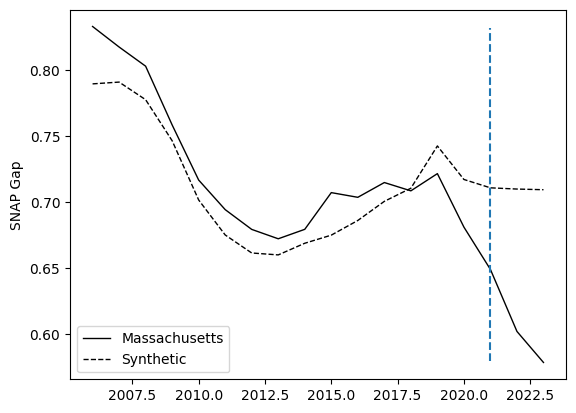

In [16]:
synth.path_plot(time_period=range(2005, 2024), treatment_time=2021, grid = False)

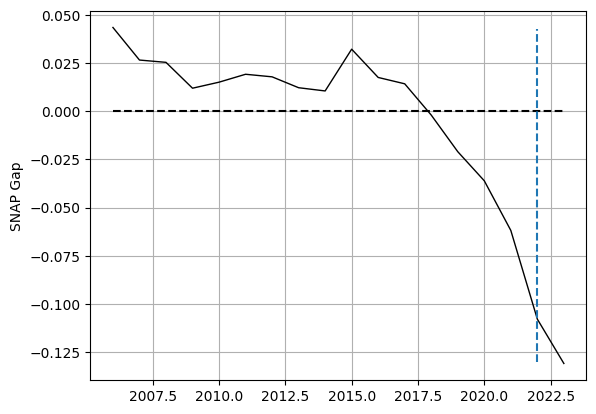

In [17]:
synth.gaps_plot(time_period=range(2005, 2024), treatment_time=2022)

In [18]:
synth.summary()

,V,treated,synthetic,sample mean
TANF apps / Ind in poverty,0.333,0.007,0.007,0.007
Child Poverty Rate,0.333,0.137,0.186,0.186
special.1.biden_2020_margin,0.333,0.335,-0.031,-0.031


In [19]:
synth.confidence_interval(
    alpha=0.1,
    time_periods=[2022, 2023],
    pre_periods=list(range(2006, 2022)),
    tol=0.05,
    verbose=False,
)

,value,lower_ci,upper_ci
time,,,
2022,-0.107984,-0.162984,-0.052984
2023,-0.131022,-0.186022,-0.076022
